In [56]:
!sudo apt install -y fluidsynth #for generating audio playback in Colab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [57]:
!pip install --upgrade pyfluidsynth #provides an interface to use fluidsynth in python

In [58]:
!pip install pretty_midi # to create and parse/process MIDI files

In [59]:
import collections #handles special container types-> dictionaries and lists
import datetime
import fluidsynth
import glob #finds file path-match
import numpy as np #numerical computations
import pathlib #manages and manipulates file system path
import pandas as pd #data analysis and manipulation
import pretty_midi
import seaborn as sns #creates statistical visuals
import tensorflow as tf #ML and deep learning tasks

from IPython import display #to display content in Jupyter notebook
from matplotlib import pyplot as plt #plots data  for visualisation
from typing import Optional #specifies optional type hints for variables

In [60]:
seed = 42 #set seed value for reproducibilty
tf.random.set_seed(seed) #ensures tf ops. produce same rand. val. each time
np.random.seed(seed) #same for numpy

# Sampling rate for audio playback
_SAMPLING_RATE = 16000 #No. of audio samples captured/sec

In [61]:
#Maestro Dataset Download
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [7]:
filenames = glob.glob(str(data_dir/'**/*.mid*')) #searches dir for .mid/.midi files
print('Number of files:', len(filenames))

Number of files: 1282


In [64]:
sample_file = filenames[1] #select a sample file to parse
print(sample_file)

data/maestro-v2.0.0/2008/MIDI-Unprocessed_12_R2_2008_01-04_ORIG_MID--AUDIO_12_R2_2008_wav--3.midi


In [65]:
pm = pretty_midi.PrettyMIDI(sample_file) #creates a prettymidi obj.

In [66]:
#Sample file playback n display
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

display_audio(pm)

In [67]:
#Name of instrument used
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [68]:
#Extraction of notes -> pitch, step, duration
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=69, note_name=A4, duration=0.2266
1: pitch=81, note_name=A5, duration=0.5508
2: pitch=48, note_name=C3, duration=0.1211
3: pitch=70, note_name=A#4, duration=0.2383
4: pitch=82, note_name=A#5, duration=0.4102
5: pitch=60, note_name=C4, duration=0.0885
6: pitch=58, note_name=A#3, duration=0.0547
7: pitch=76, note_name=E5, duration=0.0560
8: pitch=60, note_name=C4, duration=0.0495
9: pitch=64, note_name=E4, duration=0.0664


In [69]:
#Note Extraction from Sample midi file
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,81,0.957031,1.507812,0.000000,0.550781
1,69,0.981771,1.208333,0.024740,0.226562
2,82,1.790365,2.200521,0.808594,0.410156
3,48,1.816406,1.937500,0.026042,0.121094
4,70,1.824219,2.062500,0.007812,0.238281


In [70]:
#convert numeric pitch value to note names
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10] #shows note_type, accidental, octave number

array(['A5', 'A4', 'A#5', 'C3', 'A#4', 'C4', 'A#3', 'E6', 'E5', 'E4'],
      dtype='<U3')

In [71]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [72]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

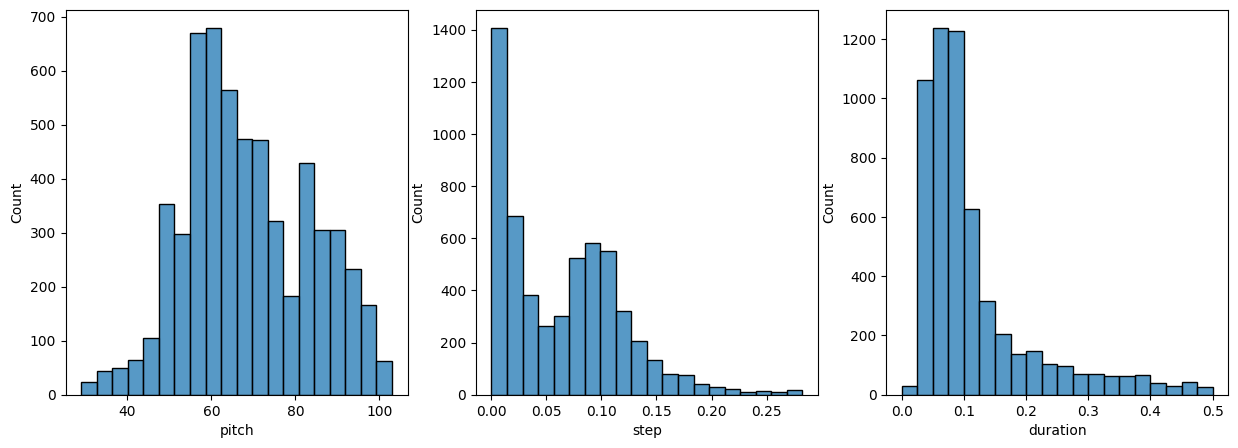

In [73]:
plot_distributions(raw_notes)

In [74]:
#Covert notes to midi
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [75]:
display_audio(example_pm)

In [76]:
#Creation of Training dataset
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes) #no of notes parsed
print('Number of notes parsed:', n_notes)

Number of notes parsed: 19038


In [77]:
#Dataset creation using parsed notes
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [78]:
#Train model on batches of sequences of notes w/ next note as label
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [79]:
seq_length = 25 #No. of notes/sequence
vocab_size = 128 #midi pitches
seq_ds = create_sequences(notes_ds, seq_length, vocab_size) #Creates dataset of sequences
seq_ds.element_spec #display

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [80]:
#Prints sequence
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[5.31250000e-01 0.00000000e+00 1.75781250e-01]
 [4.60937500e-01 1.43229167e-02 6.14583333e-01]
 [4.37500000e-01 1.30208333e-03 3.64583333e-01]
 [3.43750000e-01 1.30208333e-02 4.21875000e-01]
 [2.50000000e-01 1.30208333e-03 3.88020833e-01]
 [4.92187500e-01 1.41927083e-01 3.30729167e-01]
 [4.92187500e-01 8.60677083e-01 2.26822917e+00]
 [4.60937500e-01 9.11458333e-03 2.40104167e+00]
 [4.21875000e-01 2.60416667e-03 2.15364583e+00]
 [3.67187500e-01 1.56250000e-02 2.35026042e+00]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=83.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.20052083333333393>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.22916666666666607>}


In [81]:
#Batching examples
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [82]:
#Create & Train Model
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

#Loss function for step, duration to prevent o/p -ve values
loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 25, 3)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 128)            │         67,584 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm_2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
#Loss eval. shows pitch loss > step, duration loss
losses = model.evaluate(train_ds, return_dict=True)
losses

297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - duration_loss: 0.2353 - loss: 5.1202 - pitch_loss: 4.8544 - step_loss: 0.0304


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'duration_loss': 0.22236889600753784,
 'loss': 5.091952323913574,
 'pitch_loss': 4.838200569152832,
 'step_loss': 0.03138371556997299}

In [84]:
#Balances loss using loss_weights arg.
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

model.evaluate(train_ds, return_dict=True)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - duration_loss: 0.2353 - loss: 0.5085 - pitch_loss: 0.2427 - step_loss: 0.0304


{'duration_loss': 0.22236889600753784,
 'loss': 0.49566271901130676,
 'pitch_loss': 0.24190984666347504,
 'step_loss': 0.03138371556997299}

In [85]:
#Model Training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [86]:
#No. of Epochs
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - duration_loss: 0.1102 - loss: 0.3549 - pitch_loss: 0.2173 - step_loss: 0.0274
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - duration_loss: 0.0934 - loss: 0.3200 - pitch_loss: 0.2011 - step_loss: 0.0255
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - duration_loss: 0.0884 - loss: 0.3115 - pitch_loss: 0.1976 - step_loss: 0.0255
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - duration_loss: 0.0861 - loss: 0.3062 - pitch_loss: 0.1951 - step_loss: 0.0250
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - duration_loss: 0.0851 - loss: 0.3024 - pitch_loss: 0.1923 - step_loss: 0.0249
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - duration_loss: 0.0834 - loss: 0.2992 - pitch_loss: 0.1910 - step_loss: 0.0248
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - duration_loss: 0.0824 - loss: 0.2982 - pitch_loss: 0.1915 - step_loss: 0.0243
Epoch 8/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - duration_loss: 0.0820 

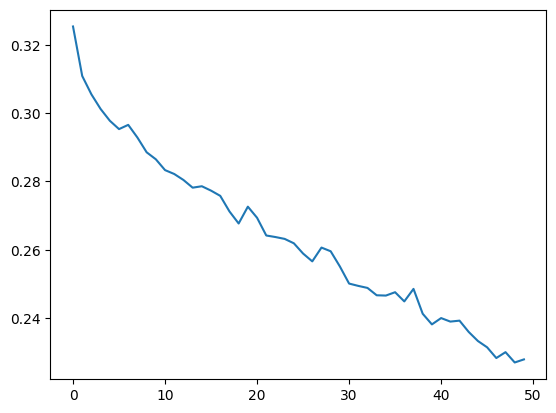

In [87]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [88]:
#Generates notes from sequence of notes
#Picks a sample from softmx distribution rather than note with highest probability as it would generate repetitive o/p
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [89]:
#Temperature to control randomness of note generated
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

In [90]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,65,0.086181,0.098526,0.086181,0.184707
1,72,0.062394,0.000000,0.148575,0.148575
2,84,0.077708,0.000000,0.226283,0.226283
3,84,0.073792,0.000000,0.300074,0.300074
4,95,0.074189,0.000000,0.374263,0.374263
5,76,0.082771,0.000000,0.457034,0.457034
6,50,0.076484,0.000000,0.533519,0.533519
7,95,0.093632,0.000000,0.627150,0.627150
8,84,0.075984,0.000000,0.703134,0.703134
9,84,0.079325,0.000000,0.782459,0.782459


In [91]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
from google.colab import files
files.download(out_file)